# Notebook for tracking mhw's
**Using Henri's [Baltic_MHW_clim](https://github.com/hdrake/MarineHeatwaveTransformations/blob/main/Baltic_MHW_clim.ipynb) *functions* to label and find mhw regions in tos data from MOM6**

### Libraries

In [2]:
import xarray as xr
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from dask.diagnostics import ProgressBar
from datetime import date
import matplotlib as mpl
from matplotlib import colors
import dask

In [3]:
from xgcm import Grid
from matplotlib.colors import NoNorm
import regionate as reg
from tqdm import tqdm

In [4]:
import json
import pickle

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds_temp = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc", chunks={'time':100})

In [135]:
ds_temp

<xarray.Dataset>
Dimensions:     (time: 1825, nv: 2, yh: 1080, xh: 1440)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0186-01-01 12:00:00 ... 0190-12-31 12:00:00
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(100, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.01860101-01901231.tos.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

In [8]:
static = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.static.nc")

In [134]:
static

<xarray.Dataset>
Dimensions:       (yh: 1080, xh: 1440, yq: 1080, xq: 1440)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables: (12/27)
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    ...            ...
    sftof         (yh, xh) float32 ...
    wet           (yh, xh) float32 ...
    wet_c         (yq, xq) float32 ...
    wet_u         (yh, xq) float32 ...
    wet_v         (yq, xh) float32 ...
    basin         (yh, xh) int32 ...
Attributes:
    external_variables:  areacello areacello

### merging static file with ds_temp

In [10]:
coords = {
    'X': {'center': 'xh', 'right': 'xq'},
    'Y': {'center': 'yh', 'right': 'yq'}
}

metrics = {
    ('X','Y'): "areacello",
}

boundary = {"X":"periodic", "Y":"periodic"}

In [11]:
coords

{'X': {'center': 'xh', 'right': 'xq'}, 'Y': {'center': 'yh', 'right': 'yq'}}

In [12]:
ds_tos_stat = xr.merge([static,ds_temp])

In [13]:
ds_tos_stat

<xarray.Dataset>
Dimensions:       (yh: 1080, xh: 1440, yq: 1080, xq: 1440, time: 1825, nv: 2)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
  * nv            (nv) float64 1.0 2.0
  * time          (time) object 0186-01-01 12:00:00 ... 0190-12-31 12:00:00
Data variables: (12/32)
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    ...            ...
    basin         (yh, xh) int32 ...
    average_DT    (time) timedelta64[ns] dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1    (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2    (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds     (time, nv) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    tos           (time, yh, xh) float32 dask.array<chunksize=(100, 1080, 1440), meta=np.ndarray>
Attributes:
    external_variables:  areacello areacello

In [14]:
grid = Grid(ds_tos_stat,coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata= False)

In [15]:
grid

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   xh --> right
  * right    xq --> center
Y Axis (periodic, boundary='periodic'):
  * center   yh --> right
  * right    yq --> center

In [16]:
t = 205

In [17]:
thresh = 29

In [18]:
mask_tos = ds_tos_stat['tos'] > thresh

In [19]:
mask_tos

<xarray.DataArray 'tos' (time: 1825, yh: 1080, xh: 1440)>
dask.array<gt, shape=(1825, 1080, 1440), dtype=bool, chunksize=(100, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 0186-01-01 12:00:00 ... 0190-12-31 12:00:00

### Using definitions for: large contiguous regions, coherent regions, consecutive coherent regions, chains of events and prolonged events

In [20]:
def masked_area(grid, mask):
    return (mask * grid._ds.areacello).sum(['xh', 'yh'])

def large_contiguous_regions(grid, mask, cutoff=(370e3)**2):
    i, j, lon_c, lat_c = reg.grid_boundaries_from_mask(grid, mask)
    regions = {}
    for r in range(len(i)):
        #print(r)
        rmask = reg.mask_from_grid_boundaries(lon_c[r], lat_c[r], grid)
        #print 
        if masked_area(grid, rmask) >= cutoff:
            regions[r] = {
                'r': r,
                'i': i[r],
                'j': j[r],
                'lon_c': lon_c[r],
                'lat_c': lat_c[r],
                'mask': rmask
            }
    return regions

In [21]:
def coherent_regions(grid, regions1, regions2):
    pairs = []
    for region1 in regions1.values():
        for region2 in regions2.values():
            if coherent_masks(region1['mask'], region2['mask']):
                pairs.append((region1, region2))
    return pairs
            
def coherent_masks(mask1, mask2):
    overlap_area = masked_area(grid, mask1 & mask2)
    return (
        (overlap_area >= 0.5*masked_area(grid, mask1)) |
        (overlap_area >= 0.5*masked_area(grid, mask2))
    )

In [22]:
def consecutive_coherent_regions(grid, masks):
    consecutive_pairs = []
    for (t1, t2) in zip(masks['time'][:-1], masks['time'][1:]):
        print(t1.values, end=", ")
        region1 = large_contiguous_regions(grid, masks.sel(time=t1))
        region2 = large_contiguous_regions(grid, masks.sel(time=t2))
        consecutive_pairs.append(
            coherent_regions(grid, region1, region2)
        )
    
    return consecutive_pairs

In [22]:
i, j, lon_c, lat_c = reg.grid_boundaries_from_mask(grid, mask_tos.isel(time=t))

In [23]:
len(lat_c)

151

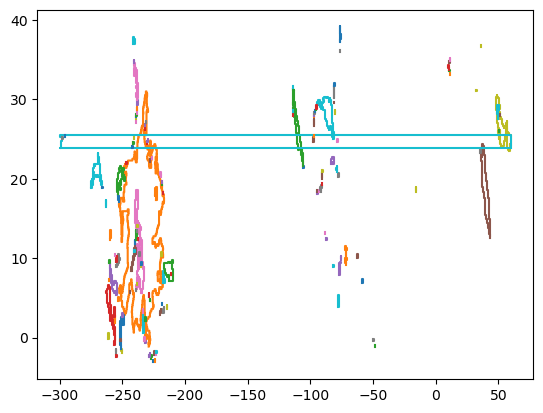

In [24]:
for (lon, lat) in zip(lon_c, lat_c):
    plt.plot(lon, lat)

reg.grid_boundaries_from_mask will show coordinates for each region

In [ ]:
reg.grid_boundaries_from_mask(grid, mask_tos.isel(time=t))

Selecting only the large regiones (above cut off) using large_contiguous_regions

In [ ]:
large_regions = large_contiguous_regions(grid, mask_tos.isel(time=t))

In [ ]:
large_regions

In [ ]:
len(large_regions)

In [ ]:
for r, r_region in large_regions.items():
    plt.plot(r_region['lon_c'], r_region['lat_c'])

In [ ]:
large_regions

In [ ]:
large_regions.keys()

##### Cell below takes the longest to run

In [23]:
#initial_day_region = large_regions

events = {}
current_event = 0
#start = 0
ndays = 2
consecutive_pairs = []
startday = t

for reference_day in range(startday, startday + ndays):
    initial_day_region = large_contiguous_regions(grid, mask_tos.isel(time=reference_day))
    next_day_region = large_contiguous_regions(grid, mask_tos.isel(time=reference_day+1))
    output = coherent_regions(grid, initial_day_region, next_day_region)
    consecutive_pairs.append(output)
    events[reference_day] = output

11 6
11 30
13 12
36 6
36 30
65 60
92 86
98 87
109 98
6 0
60 59
87 93
98 104


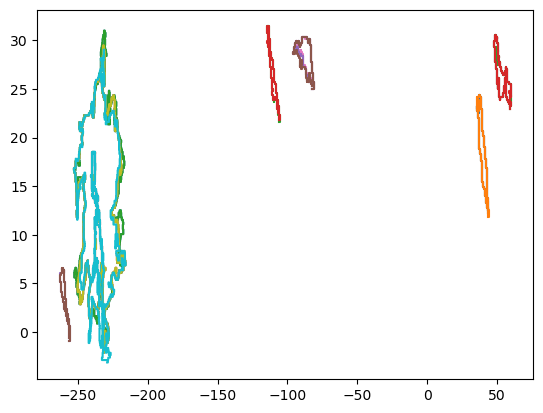

In [90]:
for value in events.values():
    for i in value:
        print(i[0]['r'],i[1]['r'])
        plt.plot(i[0]['lon_c'], i[0]['lat_c'])
        plt.plot(i[1]['lon_c'], i[1]['lat_c'])

In [25]:
import cmocean

In [26]:
cmap = plt.get_cmap("Blues_r").copy()
cmap.set_bad((0.8, 0.8, 0.8))

11 6
11 30
13 12
36 6
36 30
65 60
92 86
98 87
109 98
6 0
60 59
87 93
98 104


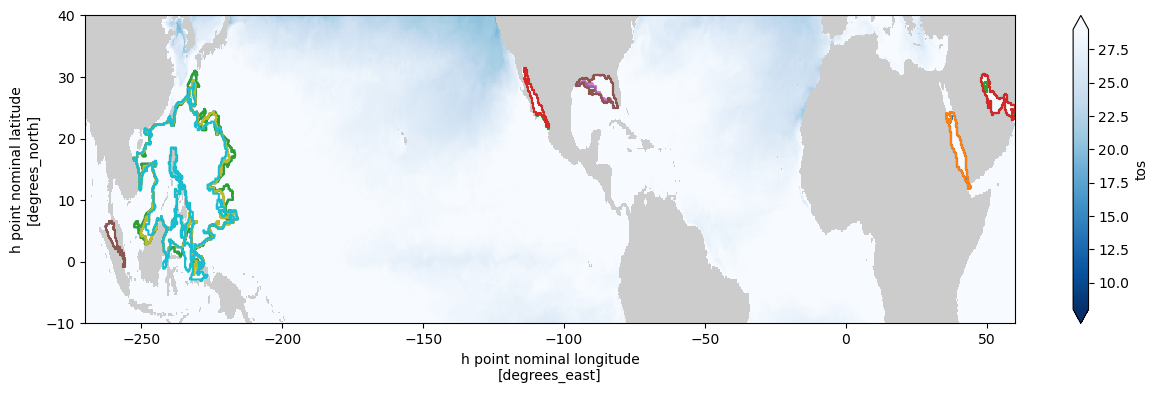

In [27]:
plt.figure(figsize=(15, 4))

pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=thresh, cmap=cmap)
#pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

for value in events.values():
    for i in value:
        print(i[0]['r'],i[1]['r'])
        plt.plot(i[0]['lon_c'], i[0]['lat_c'])
        plt.plot(i[1]['lon_c'], i[1]['lat_c'])
        plt.ylim(-10, 40)
        plt.xlim(-270, 60)

In [28]:
for n, pairs in enumerate(consecutive_pairs):
    print(n)
    print(len(pairs))
    #print(pairs)

0
9
1
4


In [29]:
def chains_of_events(consecutive_pairs):
    events = []
    for n, pairs in enumerate(consecutive_pairs):
        for p in pairs:

            new_event = True
            for event in events:
                 if (n == event[-1]["n"]+1) & (p[0]["r"] == event[-1]["r_next"]):
                    event.append({'n': n, 'r': p[0]['r'], 'r_next': p[1]['r']})
                    new_event = False
            if new_event:
                events.append([{'n': n, 'r': p[0]['r'], 'r_next': p[1]['r']}])
    for event in events:
        event.append({'n': event[-1]['n']+1, 'r': event[-1]['r_next'], 'r_next':None})
                
    return events

def prolonged_events(chains, cutoff=1):
    return [chain for chain in chains if len(chain)>=(cutoff-1)]

In [30]:
chains_of_events(consecutive_pairs)

[[{'n': 0, 'r': 11, 'r_next': 6},
  {'n': 1, 'r': 6, 'r_next': 0},
  {'n': 2, 'r': 0, 'r_next': None}],
 [{'n': 0, 'r': 11, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}],
 [{'n': 0, 'r': 13, 'r_next': 12}, {'n': 1, 'r': 12, 'r_next': None}],
 [{'n': 0, 'r': 36, 'r_next': 6},
  {'n': 1, 'r': 6, 'r_next': 0},
  {'n': 2, 'r': 0, 'r_next': None}],
 [{'n': 0, 'r': 36, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}],
 [{'n': 0, 'r': 65, 'r_next': 60},
  {'n': 1, 'r': 60, 'r_next': 59},
  {'n': 2, 'r': 59, 'r_next': None}],
 [{'n': 0, 'r': 92, 'r_next': 86}, {'n': 1, 'r': 86, 'r_next': None}],
 [{'n': 0, 'r': 98, 'r_next': 87},
  {'n': 1, 'r': 87, 'r_next': 93},
  {'n': 2, 'r': 93, 'r_next': None}],
 [{'n': 0, 'r': 109, 'r_next': 98},
  {'n': 1, 'r': 98, 'r_next': 104},
  {'n': 2, 'r': 104, 'r_next': None}]]

In [31]:
mhws = prolonged_events(chains_of_events(consecutive_pairs))

In [72]:
MHW = mhws[8]
MHW

[{'n': 0, 'r': 109, 'r_next': 98},
 {'n': 1, 'r': 98, 'r_next': 104},
 {'n': 2, 'r': 104, 'r_next': None}]

In [33]:
for event in mhws:
    print(event)

[{'n': 0, 'r': 11, 'r_next': 6}, {'n': 1, 'r': 6, 'r_next': 0}, {'n': 2, 'r': 0, 'r_next': None}]
[{'n': 0, 'r': 11, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}]
[{'n': 0, 'r': 13, 'r_next': 12}, {'n': 1, 'r': 12, 'r_next': None}]
[{'n': 0, 'r': 36, 'r_next': 6}, {'n': 1, 'r': 6, 'r_next': 0}, {'n': 2, 'r': 0, 'r_next': None}]
[{'n': 0, 'r': 36, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}]
[{'n': 0, 'r': 65, 'r_next': 60}, {'n': 1, 'r': 60, 'r_next': 59}, {'n': 2, 'r': 59, 'r_next': None}]
[{'n': 0, 'r': 92, 'r_next': 86}, {'n': 1, 'r': 86, 'r_next': None}]
[{'n': 0, 'r': 98, 'r_next': 87}, {'n': 1, 'r': 87, 'r_next': 93}, {'n': 2, 'r': 93, 'r_next': None}]
[{'n': 0, 'r': 109, 'r_next': 98}, {'n': 1, 'r': 98, 'r_next': 104}, {'n': 2, 'r': 104, 'r_next': None}]


In [ ]:
events.values()

plotting coordinates for specific regions over a series of days within each event in the mhws list

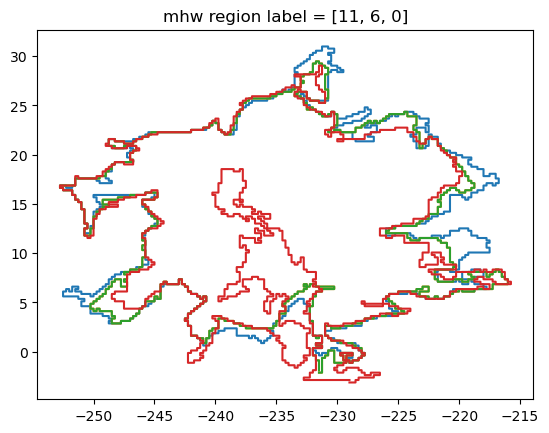

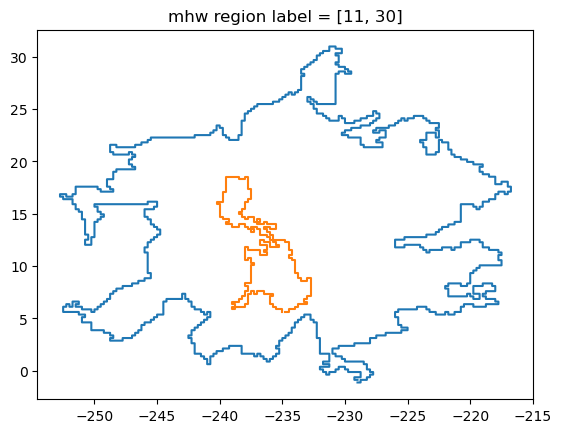

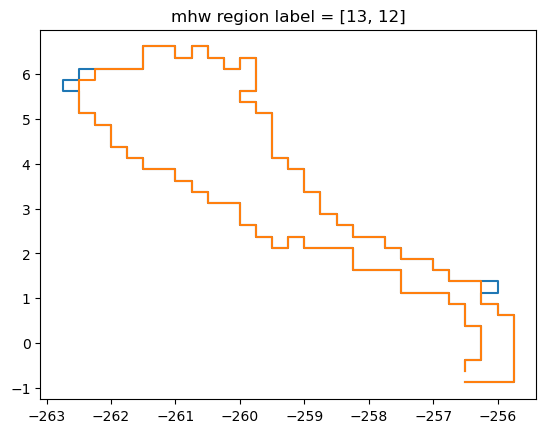

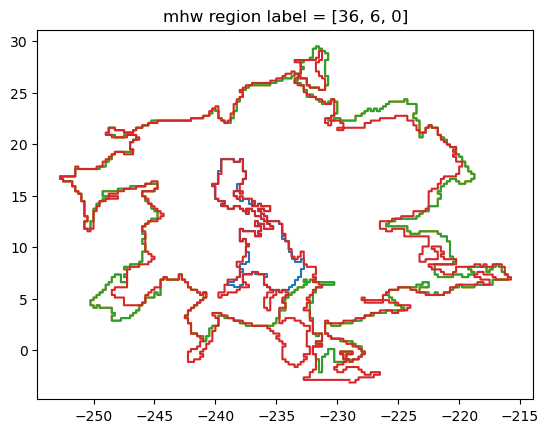

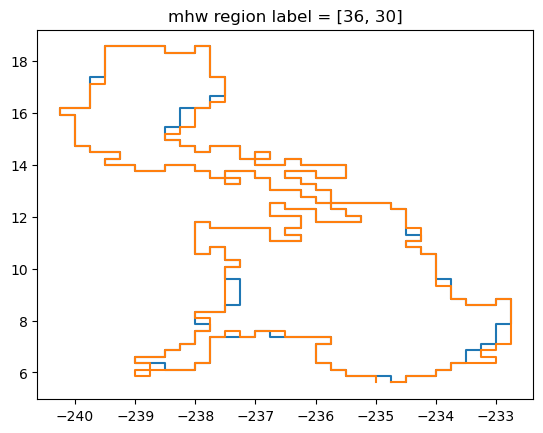

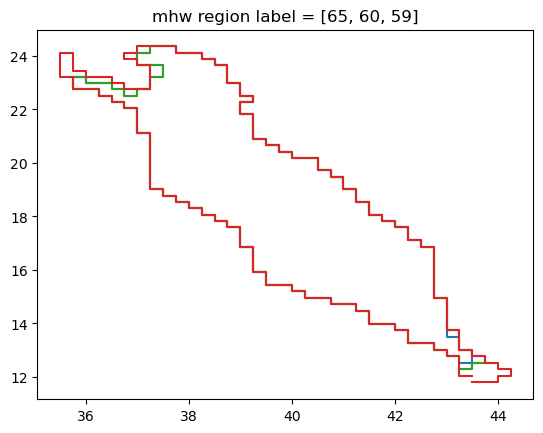

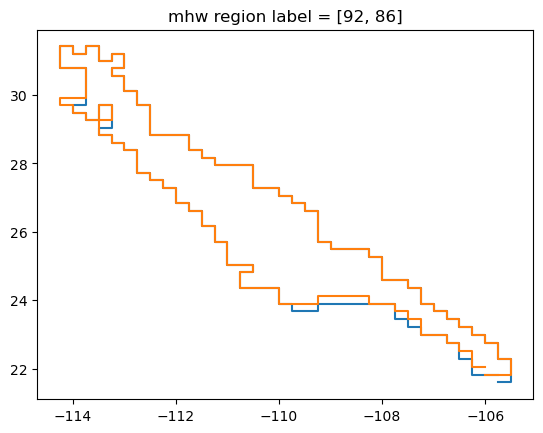

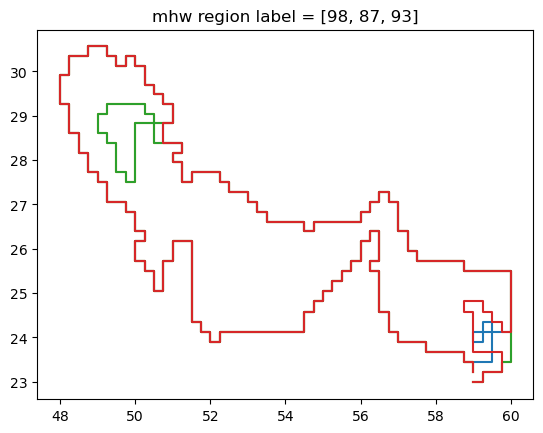

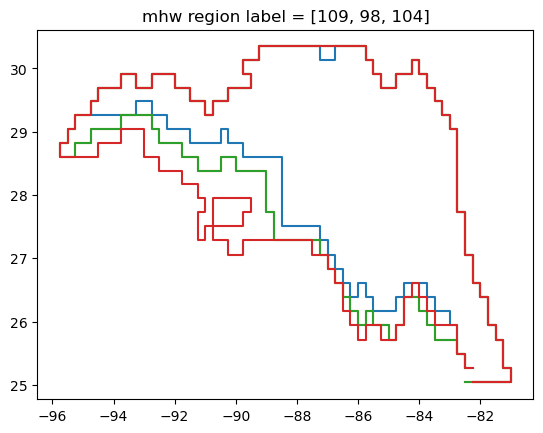

In [34]:
for event in mhws: #for each event in my list of mhw's
    plot_region_title = []
    for day in event: #iterates over each day
        plot_regions = (day['r'],day['r_next']) # each day has an 'r' key and the next day is 'r_next' meaning the next day's region
        plot_region_title += [day['r']]
        for dictionary_value in events.values(): #iterates over the values of the dictionary in events
            for mhw_item in dictionary_value: 
                if (mhw_item[0]['r'],mhw_item[1]['r']) == plot_regions: #if the information for mhw_item matches plot_regions
                    plt.plot(mhw_item[0]['lon_c'], mhw_item[0]['lat_c'])
                    plt.plot(mhw_item[1]['lon_c'], mhw_item[1]['lat_c'])
    #plt.ylim(-30, 20)
    #plt.xlim(-270, -190)
    plt.title(f"mhw region label = {plot_region_title}")
    plt.show()

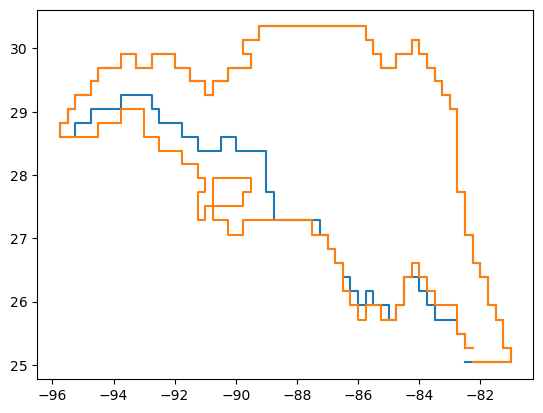

In [35]:
(i[0]['r'],i[1]['r']) == plot_regions
plt.plot(i[0]['lon_c'], i[0]['lat_c'])
plt.plot(i[1]['lon_c'], i[1]['lat_c'])

Same as cell above but with map

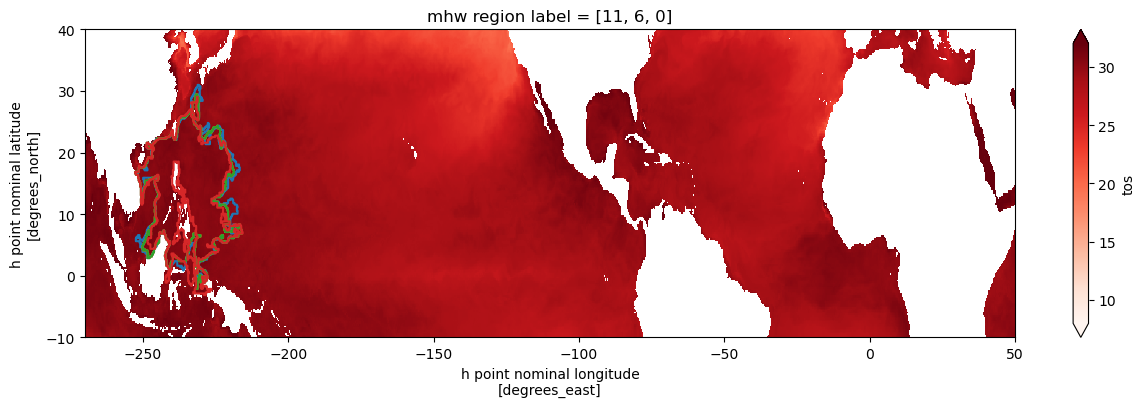

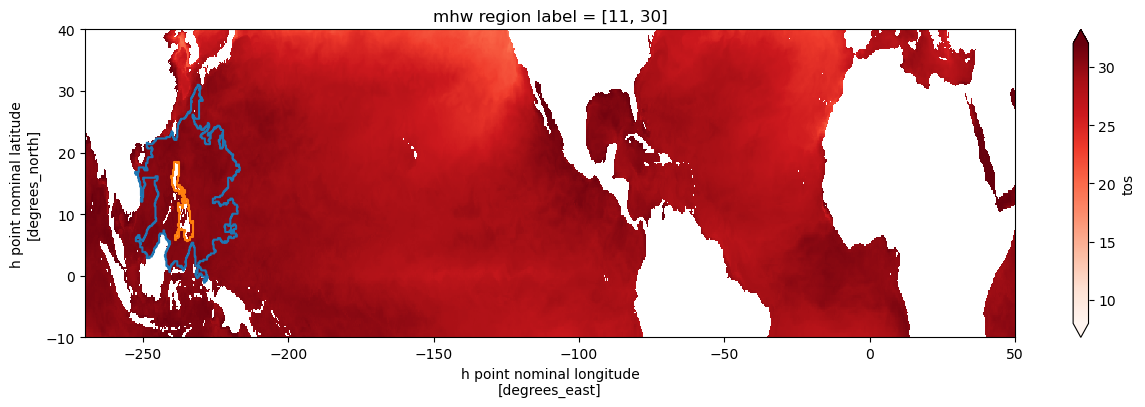

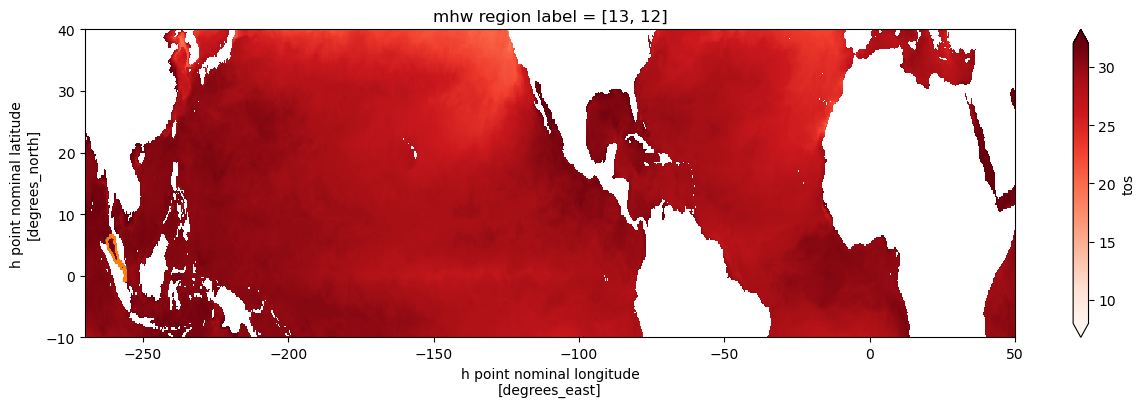

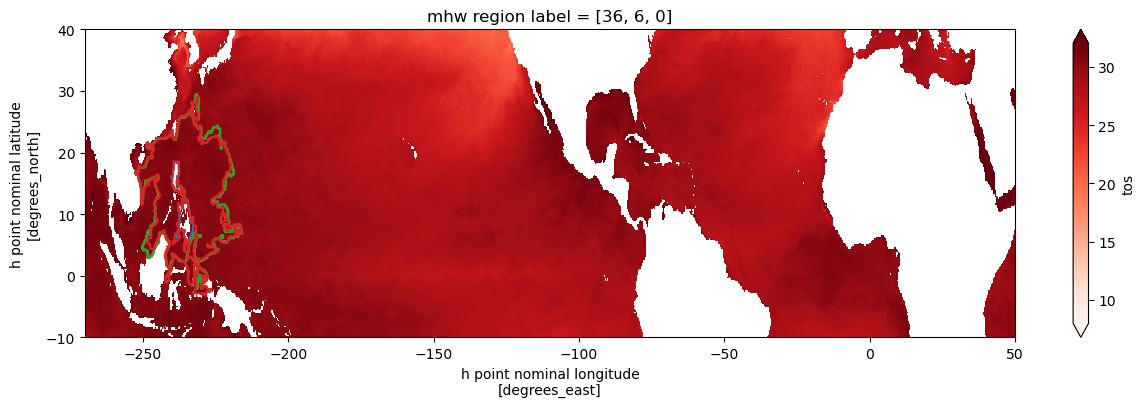

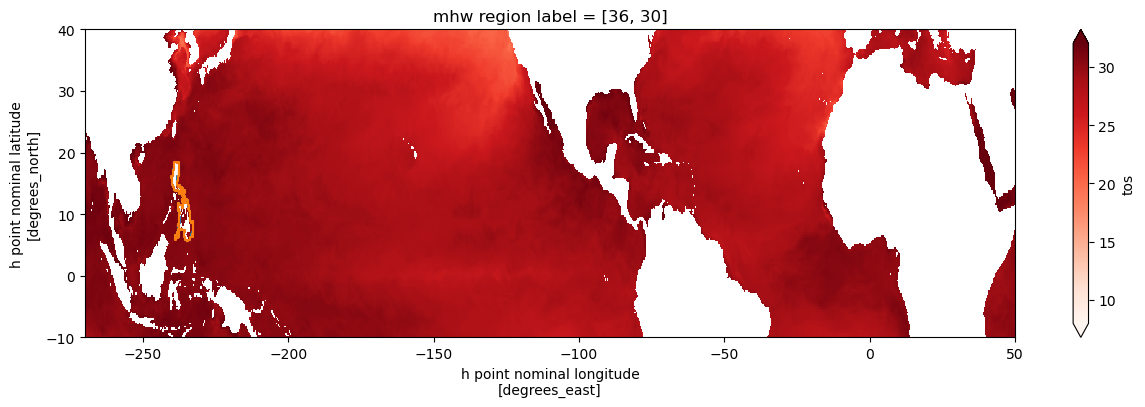

In [ ]:
for event in mhws:
    plt.figure(figsize=(15, 4))
    plt.ylim(-30, 20)
    plt.xlim(-270, -190)
    pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=32, cmap = 'Reds') #cmap=cmap
    plot_region_title = []
    for day in event: #iterates over each day
        plot_regions = (day['r'],day['r_next']) # each day has an 'r' key and the next day is 'r_next' meaning the next day's region
        plot_region_title += [day['r']]
        for dictionary_value in events.values(): #iterates over the values of the dictionary in events
            for mhw_item in dictionary_value: 
                if (mhw_item[0]['r'],mhw_item[1]['r']) == plot_regions: #if the information for mhw_item matches plot_regions
                    plt.plot(mhw_item[0]['lon_c'], mhw_item[0]['lat_c'])
                    plt.plot(mhw_item[1]['lon_c'], mhw_item[1]['lat_c'])
    plt.ylim(-10, 40)
    plt.xlim(-270, 50)
    plt.title(f"mhw region label = {plot_region_title}")
    plt.show()

In [50]:
tmp_time = ds_temp['tos'].isel(time=slice(0, 4)).max('time').compute()

In [104]:
d = ds_temp['time'].isel(time=link['n']).dt

In [123]:
t

205

Text(0.5, 1.0, 'mhw region label = [109, 98, 104]')

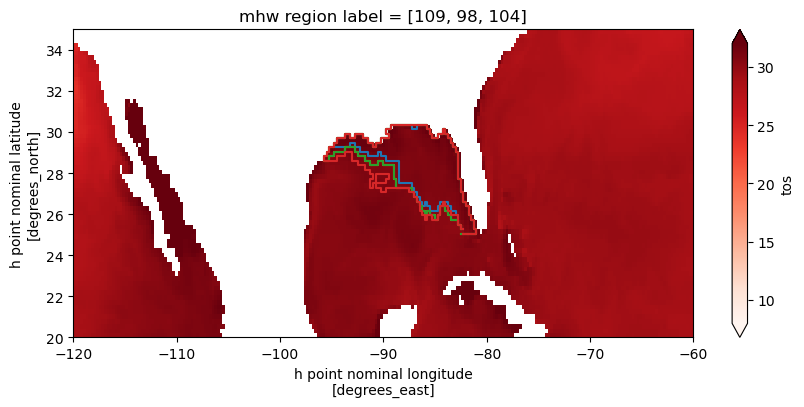

In [136]:
#selecting one specific event to plot
event = mhws[8]

plt.figure(figsize=(10, 4))
plt.ylim(20, 35)
plt.xlim(-120, -60)
pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=32, cmap = 'Reds') #cmap=cmap
plot_region_title = []
for day in event: #iterates over each day
    plot_regions = (day['r'],day['r_next']) # each day has an 'r' key and the next day is 'r_next' meaning the next day's region
    plot_region_title += [day['r']]
    for dictionary_value in events.values(): #iterates over the values of the dictionary in events
        for mhw_item in dictionary_value: 
            if (mhw_item[0]['r'],mhw_item[1]['r']) == plot_regions: #if the information for mhw_item matches plot_regions
                plt.plot(mhw_item[0]['lon_c'], mhw_item[0]['lat_c'])
                plt.plot(mhw_item[1]['lon_c'], mhw_item[1]['lat_c'])
plt.ylim(20, 35)
plt.xlim(-120, -60)
plt.title(f"mhw region label = {plot_region_title}")

In [81]:
mhws[8]

[{'n': 0, 'r': 109, 'r_next': 98},
 {'n': 1, 'r': 98, 'r_next': 104},
 {'n': 2, 'r': 104, 'r_next': None}]

In [ ]:
consecutive_pairs[link['n']]

In [71]:
mhw_snaps = MHW[:-1]
mhw_snaps

[{'n': 0, 'r': 109, 'r_next': 98}, {'n': 1, 'r': 98, 'r_next': 104}]

In [138]:
mhws

[[{'n': 0, 'r': 11, 'r_next': 6},
  {'n': 1, 'r': 6, 'r_next': 0},
  {'n': 2, 'r': 0, 'r_next': None}],
 [{'n': 0, 'r': 11, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}],
 [{'n': 0, 'r': 13, 'r_next': 12}, {'n': 1, 'r': 12, 'r_next': None}],
 [{'n': 0, 'r': 36, 'r_next': 6},
  {'n': 1, 'r': 6, 'r_next': 0},
  {'n': 2, 'r': 0, 'r_next': None}],
 [{'n': 0, 'r': 36, 'r_next': 30}, {'n': 1, 'r': 30, 'r_next': None}],
 [{'n': 0, 'r': 65, 'r_next': 60},
  {'n': 1, 'r': 60, 'r_next': 59},
  {'n': 2, 'r': 59, 'r_next': None}],
 [{'n': 0, 'r': 92, 'r_next': 86}, {'n': 1, 'r': 86, 'r_next': None}],
 [{'n': 0, 'r': 98, 'r_next': 87},
  {'n': 1, 'r': 87, 'r_next': 93},
  {'n': 2, 'r': 93, 'r_next': None}],
 [{'n': 0, 'r': 109, 'r_next': 98},
  {'n': 1, 'r': 98, 'r_next': 104},
  {'n': 2, 'r': 104, 'r_next': None}]]

In [140]:
id = 109
blob = mhw_item.where(mhw_item==id, drop=True)
blob.shape

AttributeError: 'tuple' object has no attribute 'where'

In [ ]:
mhw_snaps = MHW[:-1]
for i, link in enumerate(mhw_snaps):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    print(mask)
    color = cmocean.cm.dense((i/len(mhw_snaps) + 0.4)/1.4)
    mask.plot.contour(levels=[0.5], colors=[color], linewidths=1.25, alpha=0.85)
    d = ds_temp['time'].isel(time=link['n']).dt
    plt.plot([], [], label=f"{d.year.values}-{d.month.values:02}-{d.day.values:02}", color=color)

Text(0, 0.5, 'latitude')

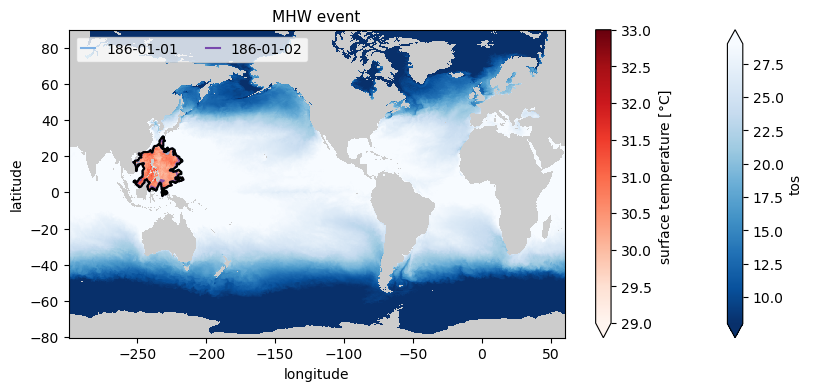

In [73]:
MHW = mhws[8]

plt.figure(figsize=(10, 4))

pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=thresh, cmap=cmap) #each location it's trying to fiure out what the max temperature was, broadcasting an operation over the whole
#pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

event_mask = xr.zeros_like(mask_tos.isel(time=t))
for i, link in enumerate(mhws[8][:-1]):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    event_mask = mask | event_mask

pc = ds_temp['tos'].max('time').where(event_mask).plot(cmap="Reds", vmin=thresh, vmax=33)
pc.colorbar.set_label("surface temperature [$\degree$C]")
#pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

mhw_snaps = MHW[:-1]
for i, link in enumerate(mhw_snaps):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    color = cmocean.cm.dense((i/len(mhw_snaps) + 0.4)/1.4)
    mask.plot.contour(levels=[0.5], colors=[color], linewidths=1.25, alpha=0.85)
    d = ds_temp['time'].isel(time=link['n']).dt
    plt.plot([], [], label=f"{d.year.values}-{d.month.values:02}-{d.day.values:02}", color=color)

event_mask.plot.contour(levels=[0.5], colors="k")
plt.legend(labelspacing=0.08, ncol=2, handlelength=1., loc="upper left")
#plt.ylim(-30, 20)
#plt.xlim(-270, -190)
plt.title("MHW event", fontsize=11)
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'latitude')

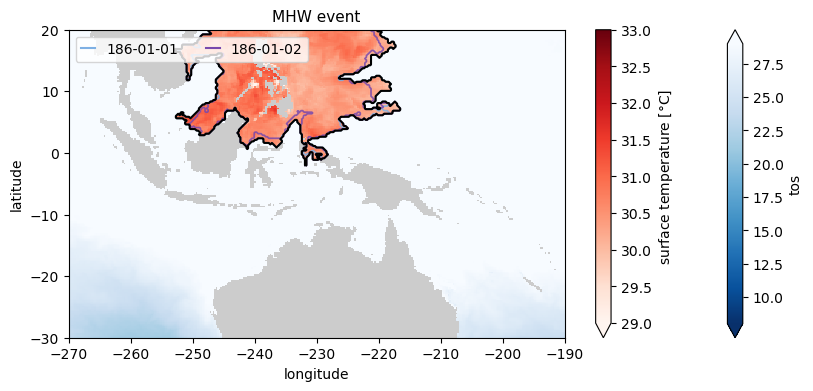

In [53]:
plt.figure(figsize=(10, 4))

pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=thresh, cmap=cmap) #each location it's trying to fiure out, broadcasting an operation
#pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

event_mask = xr.zeros_like(mask_tos.isel(time=t))
for i, link in enumerate(mhws[0][:-1]):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    event_mask = mask | event_mask

pc = ds_temp['tos'].max('time').where(event_mask).plot(cmap="Reds", vmin=thresh, vmax=33)
pc.colorbar.set_label("surface temperature [$\degree$C]")
#pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

mhw_snaps = MHW[:-1]
for i, link in enumerate(mhw_snaps):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    color = cmocean.cm.dense((i/len(mhw_snaps) + 0.4)/1.4)
    mask.plot.contour(levels=[0.5], colors=[color], linewidths=1.25, alpha=0.85)
    d = ds_temp['time'].isel(time=link['n']).dt
    plt.plot([], [], label=f"{d.year.values}-{d.month.values:02}-{d.day.values:02}", color=color)

event_mask.plot.contour(levels=[0.5], colors="k")
plt.legend(labelspacing=0.08, ncol=2, handlelength=1., loc="upper left")
plt.ylim(-30, 20)
plt.xlim(-270, -190)
plt.title("MHW event", fontsize=11)
plt.xlabel("longitude")
plt.ylabel("latitude")

In [96]:
f"{d.year.values}-{d.month.values:02}-{d.day.values:02}"

'186-01-01'

In [111]:
f"{d.month.values:02}"

'01'

In [109]:
d.month.values

array(1)

In [98]:
ds_temp['time'].isel(time=link['n'])

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(186, 1, 1, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0186-01-01 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds
    cell_methods:   time: mean

In [ ]:
pc = ds_temp['tos'].max('time').plot(vmin=8, vmax=.values, cmap=cmap)
pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

event_mask = xr.zeros_like(mask_tos.isel(time=0))
for i, link in enumerate(mhws[0][:-1]):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    event_mask = mask | event_mask
    
pc = ds['tos'].max('time').where(event_mask).plot(cmap="Reds", vmin=.values, vmax=21.5)
pc.colorbar.set_label("annual-max daily-mean surface temperature [$\degree$C]")

MHW_snaps = MHW[:-1][::2]
for i, link in enumerate(MHW_snaps):
    mask = consecutive_pairs[link['n']][0][0]['mask']
    color = cmocean.cm.dense((i/len(MHW_snaps) + 0.4)/1.4)
    mask.plot.contour(levels=[0.5], colors=[color], linewidths=1.25, alpha=0.85)
    d = ds['time'].isel(time=link['n']).dt
    plt.plot([], [], label=f"{d.year.values}-{d.month.values:02}-{d.day.values:02}", color=color)
    
event_mask.plot.contour(levels=[0.5], colors="k")
plt.legend(labelspacing=0.08, ncol=2, handlelength=1., loc="upper left")
#plt.ylim(53, 64)
plt.xlim(6, 26.25)
plt.title("b) Temporal evolution of a Baltic Sea MHW event", fontsize=11)
plt.xlabel("longitude")
plt.ylabel("latitude")